In [1]:
!pip install gymnasium numpy matplotlib -q

In [2]:
import warnings
warnings.filterwarnings("ignore")

# **GYM ENV**

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm, trange
from typing import Optional

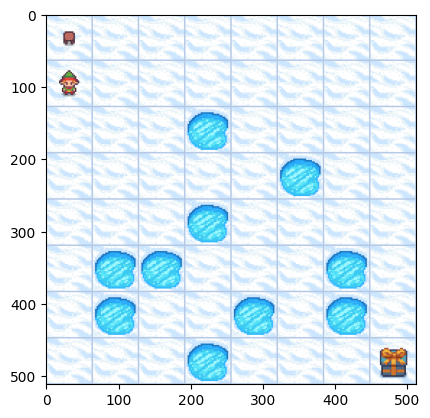

In [4]:
# Create the FrozenLake environment (4x4 grid)
env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name="8x8", is_slippery=True)

# Reset the environment to start
state, info = env.reset()
action = env.action_space.sample()
state, reward, terminated, truncated, _ = env.step(action)

# Render the environment
frame = env.render()
plt.imshow(frame)

In [41]:
def plot_result(total_reward_per_run, regret_per_run, num_episodes , num_runs,
              figsize = (15,4), title = ''):

  fig, ax = plt.subplots(figsize = figsize)

  # Total_reward
  mean_total_reward_per_run = np.mean(np.array(total_reward_per_run), axis = 0)
  std_total_reward_per_run = np.std(np.array(total_reward_per_run), axis = 0)
  up_bound_total_reward = mean_total_reward_per_run + 1.96 * std_total_reward_per_run/np.sqrt(num_runs)
  low_bound_total_reward = mean_total_reward_per_run - 1.96 * std_total_reward_per_run/np.sqrt(num_runs)
  ax.plot(range(num_episodes), mean_total_reward_per_run, label = 'Total_Reward')
  ax.fill_between(range(num_episodes), low_bound_total_reward, up_bound_total_reward, alpha = 0.5)


  # # Regret
  mean_regret_per_run = np.mean(np.array(regret_per_run), axis = 0)
  std_regret_per_run = np.std(np.array(regret_per_run), axis = 0)
  up_bound_regret = mean_regret_per_run + 1.96 * std_regret_per_run/np.sqrt(num_runs)
  low_bound_regret = mean_regret_per_run - 1.96 * std_regret_per_run/np.sqrt(num_runs)
  ax.plot(range(num_episodes), mean_regret_per_run, label = 'Regret')
  ax.fill_between(range(num_episodes),low_bound_regret, up_bound_regret, alpha = 0.5)


  plt.title(title)
  plt.ylabel('Reward')
  plt.xlabel('episode')
  plt.legend()
  plt.show()

# **Monte Carlo**

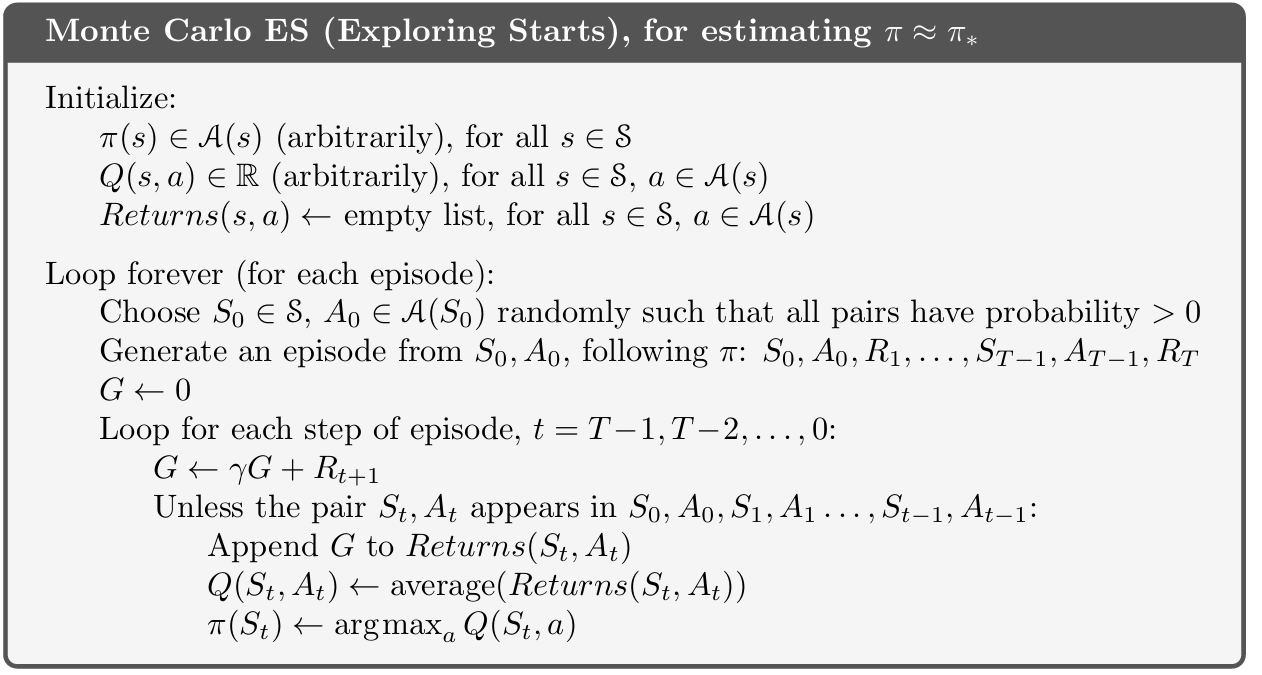

In [12]:
class MonteCarlo:

    def __init__(self, env, discount=0.99, epsilon=1.0, epsilon_decay=None):

        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.q_table = np.zeros((self.state_size, self.action_size))

        self.returns_sum = np.zeros((self.state_size, self.action_size))
        self.returns_count = np.zeros((self.state_size, self.action_size))

        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def train(self, episodes):
        total_rewards = []
        regrets = []

        for i in trange(episodes):
            state, _ = self.env.reset()
            episode = []

            while True:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state
                if terminated or truncated:
                    break

            G = 0
            visited_state_action_pairs = set()
            for state, action, reward in reversed(episode):
                G = self.discount * G + reward
                if (state, action) not in visited_state_action_pairs:
                    self.returns_sum[state, action] += G
                    self.returns_count[state, action] += 1
                    self.q_table[state, action] = self.returns_sum[state, action] / self.returns_count[state, action]
                    visited_state_action_pairs.add((state, action))

            total_rewards.append(sum(x[2] for x in episode))
            regrets.append(sum(10 - x[2] for x in episode))

            if (self.epsilon_decay) and (self.epsilon > self.epsilon_min):
                self.epsilon *= self.epsilon_decay

        return regrets, total_rewards

In [13]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name="4x4", is_slippery=False)

num_runs = 3
num_episodes = 2000

discount = 0.998
epsilon = 1
epsilon_decay = 0.995

total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = MonteCarlo(env, discount, epsilon, epsilon_decay)
  total_reward = agent.train(num_episodes)

  total_reward_per_run.append(total_reward)

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
plot_result(total_reward_per_run, [], num_episodes , num_runs,
              figsize = (15,4), title = 'Monte Carlo Convergence')

# **SARSA**

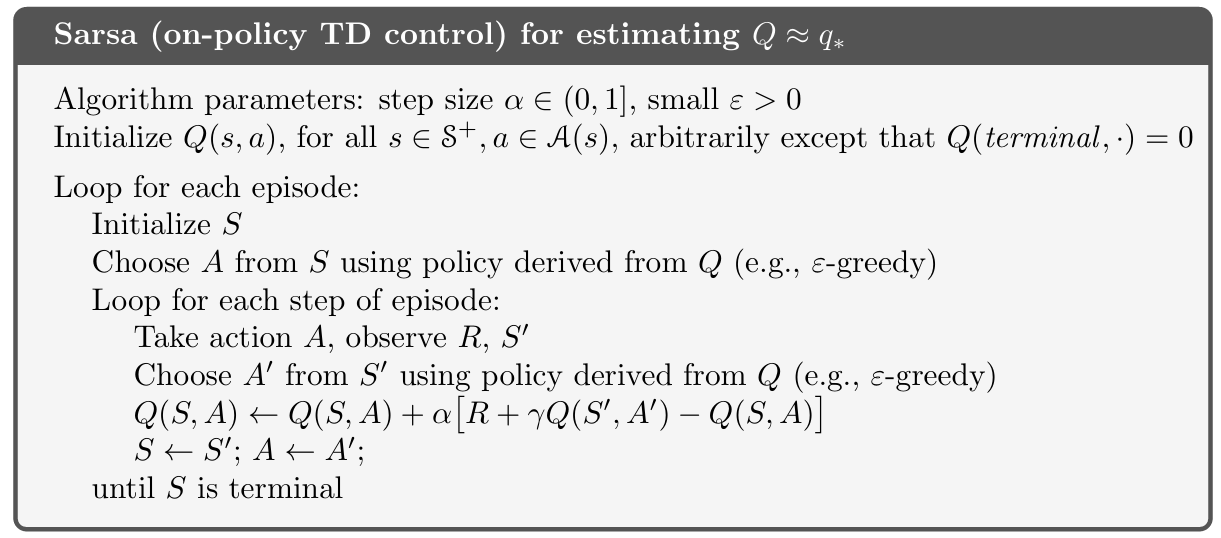

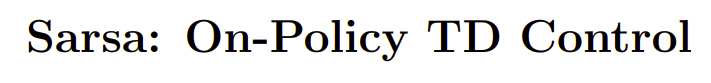

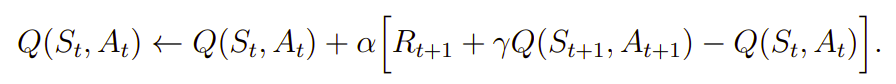

In [ ]:
class SARSA:

  def __init__(self, env, learning_rate = 0.1, discount = 0.99, epsilon = 1, epsilon_decay:Optional[float]= None):

    self.env = env
    self.state_size = env.observation_space.n
    self.action_space = env.action_space
    self.action_size = env.action_space.n
    self.q_table = np.zeros((self.state_size, self.action_size))

    self.learning_rate = learning_rate
    self.discount = discount
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = 0.01


  def get_action(self, state):
    if np.random.rand() < self.epsilon:
      return env.action_space.sample()
    else:
      return np.argmax(self.q_table[state])

  def train(self, episodes):

    regrets = []
    total_rewards = []
    frames = []

    for episode in trange(episodes):

      state, _ = self.env.reset()
      action = self.get_action(state)
      total_reward = 0
      frames_per_episode = []

      while True:

        next_state, reward, terminated, truncated, _  = self.env.step(action)
        next_action = self.get_action(next_state)

        current_q = self.q_table[state, action]
        next_q = self.q_table[next_state, next_action]

        # Write SARSA updating rule
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + (self.discount * next_q))
        self.q_table[state , action] = new_q


        total_reward += reward
        state = next_state
        action = next_action

        if terminated or truncated:
          # Calcualte regret
          regret = 1 - total_reward
          regrets.appned(regret)
          total_rewards.append(total_reward)
          break

        if episode % 20 == 0:
          frames_per_episode.append(self.env.render())

      if frames_per_episode:
        frames.append(frames_per_episode)

      if (self.epsilon_decay) and (self.epsilon > self.epsilon_min):
        self.epsilon = self.epsilon * self.epsilon_decay

    return regrets, total_rewards, frames

In [ ]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name="4x4", is_slippery=False)

num_runs = 3
num_episodes = 2000

learning_rate = 0.01
discount = 0.90
epsilon = 1
epsilon_decay = 0.5

regret_per_run = []
total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = SARSA(env, learning_rate, discount, epsilon_decay)
  regret, total_reward, frames = agent.train(num_episodes)

  regret_per_run.append(regret)
  total_reward_per_run.append(total_reward)

In [ ]:
plot_result(total_reward_per_run, regret_per_run, num_episodes , num_runs,
              figsize = (15,4), title = 'SARSA Convergence')

In [ ]:
print(len(frames))

In [ ]:
import imageio.v2 as imageio
gif_filename = 'output_qlearning.gif'
imageio.mimsave(gif_filename, frames[75], fps=2)

from IPython.display import Image, display
display(Image(filename=gif_filename))

**Reward editing SARSA:**
---

In [ ]:
class SARSA_Reward_edit:

  def __init__(self, env, learning_rate = 0.1, discount = 0.99, epsilon = 1, epsilon_decay:Optional[float]= None):

    self.env = env
    self.state_size = env.observation_space.n
    self.action_space = env.action_space
    self.action_size = env.action_space.n
    self.q_table = np.zeros((self.state_size, self.action_size))

    self.learning_rate = learning_rate
    self.discount = discount
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = 0.01


  def get_action(self, state):
    if np.random.rand() < self.epsilon:
      return env.action_space.sample()
    else:
      return np.argmax(self.q_table[state])

  def train(self, episodes):

    regrets = []
    total_rewards = []
    frames = []

    for episode in trange(episodes):

      state, _ = self.env.reset()
      action = self.get_action(state)
      total_reward = 0

      while True:


        next_state, reward, terminated, truncated, _  = self.env.step(action)
        next_action = self.get_action(next_state)

        current_q = self.q_table[state, action]
        next_q = self.q_table[next_state, next_action]

        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + (self.discount * next_q))
        self.q_table[state , action] = new_q

        ## Reward editing
        if reward == 0 and terminated:
          reward = -1
        elif reward == 1:
          reward = 5 #2
        elif reward == 0:
          reward = -0.1

        total_reward += reward
        state = next_state
        action = next_action

        if episode == episodes-1:
          frames.append(self.env.render())

        if terminated or truncated:
          # Calcualte regret
          regret = 4.4 - total_reward
          regrets.append(regret)
          total_rewards.append(total_reward)
          break

      if (self.epsilon_decay) and (self.epsilon > self.epsilon_min):
        self.epsilon = self.epsilon * self.epsilon_decay

    return regrets, total_rewards, frames

In [ ]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name="4x4", is_slippery=False)

num_runs = 1
num_episodes = 2000

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.5

regret_per_run = []
total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = SARSA_Reward_edit(env, learning_rate, discount, epsilon_decay)
  regret, total_reward, frames = agent.train(num_episodes)

  regret_per_run.append(regret)
  total_reward_per_run.append(total_reward)

In [ ]:
plot_result(total_reward_per_run, regret_per_run, num_episodes , num_runs,
              figsize = (15,4), title = 'SARSA Convergence')

In [ ]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name="4x4", is_slippery=False)

num_runs = 1
num_episodes = 2000

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.5

regret_per_run = []
total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = SARSA_Reward_edit(env, learning_rate, discount, epsilon_decay)
  regret, total_reward, frames = agent.train(num_episodes)

  regret_per_run.append(regret)
  total_reward_per_run.append(total_reward)

In [ ]:
plot_result(total_reward_per_run, regret_per_run, num_episodes , num_runs,
              figsize = (15,4), title = 'SARSA Convergence')

# **Q-Learning**

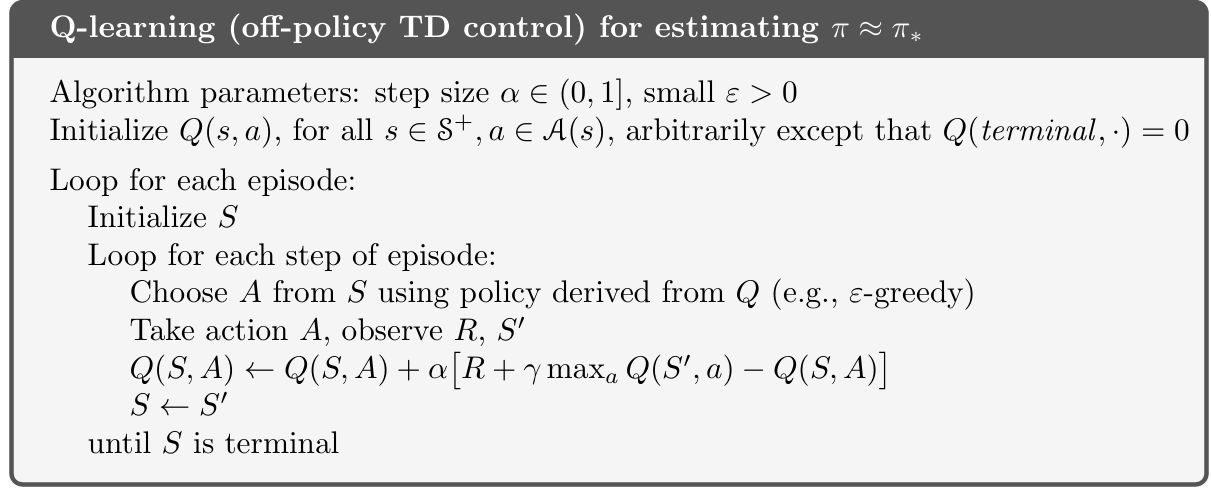

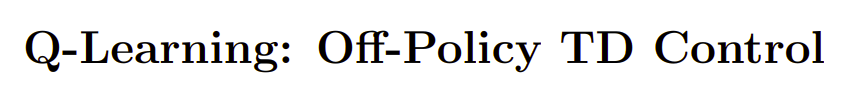

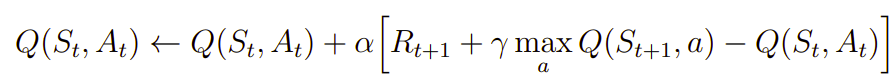

In [26]:
class QLearning:

  def __init__(self, env, learning_rate = 0.1, discount = 0.99, epsilon = 1, epsilon_decay:Optional[float]= None):

    self.env = env
    self.state_size = env.observation_space.n
    self.action_space = env.action_space
    self.action_size = env.action_space.n
    self.q_table = np.zeros((self.state_size, self.action_size))

    self.learning_rate = learning_rate
    self.discount = discount
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay


  def get_action(self, state):
    if np.random.rand() < self.epsilon:
      return env.action_space.sample()
    else:
      return np.argmax(self.q_table[state])

  def train(self, episodes):

    regrets = []
    total_rewards = []
    frames = []

    for episode in trange(episodes):

      state, _ = self.env.reset()
      total_reward = 0

      while True:

        action = self.get_action(state)
        next_state, reward, terminated, truncated, _ = self.env.step(action)

        current_q = self.q_table[state, action]
        next_max_q = np.max(self.q_table[next_state])

        # Write Q-Learning updating rule
        new_q = current_q + self.learning_rate*(reward + self.discount*next_max_q - current_q)
        self.q_table[state , action] = new_q

        total_reward += reward
        state = next_state

        if episode == episodes-1:
          frames.append(self.env.render())

        if terminated or truncated:
          # Calcualte regret
          regret = 9 - total_reward
          regrets.append(regret)
          total_rewards.append(total_reward)
          break

      if (self.epsilon_decay):
        self.epsilon = max(0.01, self.epsilon_decay * self.epsilon )

    return regrets, total_rewards, frames

In [27]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name="4x4", is_slippery=False)

num_runs = 3
num_episodes = 2000

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.5

regret_per_run = []
total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = QLearning(env, learning_rate, discount, epsilon_decay)
  regret, total_reward, frames = agent.train(num_episodes)

  regret_per_run.append(regret)
  total_reward_per_run.append(total_reward)

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

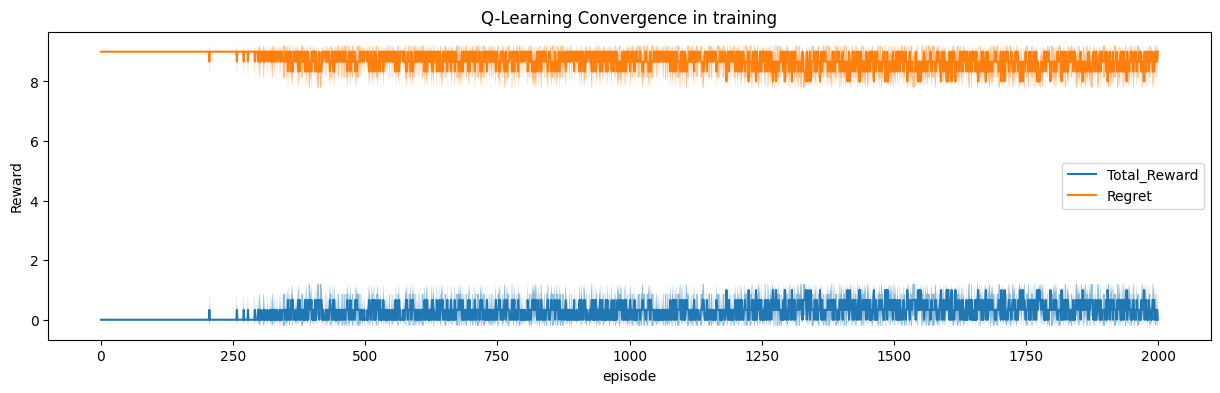

In [28]:
plot_result(total_reward_per_run, regret_per_run, num_episodes , num_runs,
              figsize = (15,4), title = 'Q-Learning Convergence in training')

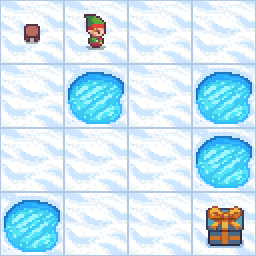

In [29]:
import imageio.v2 as imageio
gif_filename = 'output_qlearning.gif'
imageio.mimsave(gif_filename, frames, fps=1)

from IPython.display import Image, display
display(Image(filename=gif_filename))

# **Custome ENV**

The environment is a 6x6 custom Frozen Lake with the following characteristics:
---
1- The start position is at (0, 0) and the end position is at (5, 5).
---
2- There is a slip probability of 0.06 in all directions.
---
3- Only one path leads to the end, with a breaking probability of 0.0001 on each square.
---
4- Rewards are as follows: reaching the end gives +10, breaking the ice results in -2, and each step taken incurs a penalty of -0.1."
---

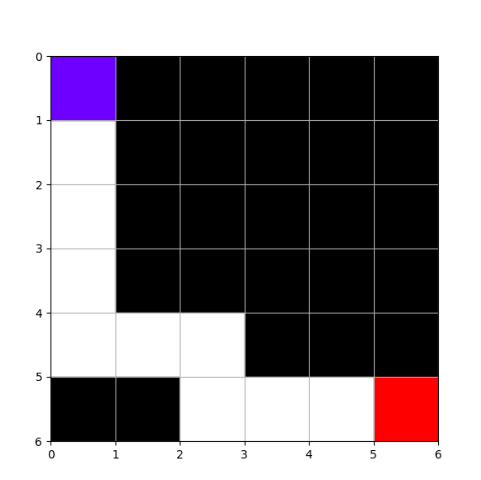

In [30]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [31]:
class FrozenLakeCustomEnv(gym.Env):
    def __init__(self, max_steps=300, seed=None):
        super(FrozenLakeCustomEnv, self).__init__()

    def step(self, action):
        return

    def reset(self, *, seed=None, options=None):
        return

    def render(self, mode="rgb_array"):
        return



In [32]:
class FrozenLakeCustomEnv(gym.Env):
    def __init__(self, max_steps=300, seed=None):
        super(FrozenLakeCustomEnv, self).__init__()

        self.grid_size = 6
        self.start = (0, 0)
        self.goal = (5, 5)
        self.max_steps = max_steps
        self.current_step = 0
        self.action_space = spaces.Discrete(4)  # 0: left, 1: down, 2: right, 3: up
        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)

        self.state = self.start
        self.slip_prob = 0.06
        self.rng = np.random.default_rng(seed)

        self.grid = np.ones((self.grid_size, self.grid_size))
        self.safe_path = self._generate_random_safe_path()

        # Create the grid
        for pos in self.safe_path:
            self.grid[pos] = 0.0001

        # Ensure start and goal points are always safe
        self.grid[self.start] = 0
        self.grid[self.goal] = 0

    def _generate_random_safe_path(self):
        path = [self.start]
        current_pos = self.start

        while current_pos != self.goal:
            possible_moves = []
            x, y = current_pos
            if x < self.grid_size - 1:  # Can move down
                possible_moves.append((x + 1, y))
            if y < self.grid_size - 1:  # Can move right
                possible_moves.append((x, y + 1))


            next_pos = self.rng.choice(possible_moves)
            next_pos = tuple(next_pos)
            if next_pos not in path:
                path.append(next_pos)
            current_pos = next_pos

        return path

    def step(self, action):
        self.current_step += 1
        if self.rng.random() < self.slip_prob:
            action = self.rng.choice([0, 1, 2, 3])

        next_state = self._move(self.state, action)
        x, y = next_state

        terminated = next_state == self.goal
        truncated = self.current_step >= self.max_steps
        done = terminated or truncated

        if terminated:
            reward = 10
        elif self.grid[x, y] == 1:
            reward = -2
            terminated = True
        else:
            reward = np.random.normal(-0.1, 0.05)

        self.state = next_state if not done else self.start
        return self._state_to_index(next_state), reward, terminated, truncated, {}

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.safe_path = self._generate_random_safe_path()
        self.state = self.start
        self.current_step = 0
        return self._state_to_index(self.state), {}

    def render(self, mode="rgb_array"):
        fig, ax = plt.subplots(figsize=(6, 6))
        canvas = FigureCanvas(fig)

        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size + 1, 1))
        ax.set_yticks(np.arange(0, self.grid_size + 1, 1))
        ax.grid(True)

        for y in range(self.grid_size):
            for x in range(self.grid_size):
                if (x, y) == self.start:
                    color = 'green'
                elif (x, y) == self.goal:
                    color = 'red'
                elif self.grid[x, y] == 1:
                    color = 'black'
                else:
                    color = 'white'

                square = patches.Rectangle((y, x), 1, 1, color=color)
                ax.add_patch(square)

        current_x, current_y = self.state
        player = patches.Rectangle((current_y, current_x), 1, 1, color='blue')
        ax.add_patch(player)

        plt.gca().invert_yaxis()
        plt.close(fig)  # Don't display the plot

        canvas.draw()
        frame = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return frame

    def _move(self, state, action):
        x, y = state
        if action == 0:  # Left
            y = max(y - 1, 0)
        elif action == 1:  # Down
            x = min(x + 1, self.grid_size - 1)
        elif action == 2:  # Right
            y = min(y + 1, self.grid_size - 1)
        elif action == 3:  # Up
            x = max(x - 1, 0)
        return x, y

    def _state_to_index(self, state):
        x, y = state
        # Convert coordinates to a unique index
        return x * self.grid_size + y

    def _index_to_state(self, index):
        x = index // self.grid_size
        y = index % self.grid_size
        # Convert unique index back to coordinates
        return (x, y)


In [33]:
env = FrozenLakeCustomEnv(max_steps=10)

state, _ = env.reset()

done = False
frames = []
while not done:
    frame = env.render()
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    print(f"Action: {action}, State: {state}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}")
    print()
    done = terminated or  truncated
    frames.append(frame)


Action: 3, State: 0, Reward: -0.10278125289057038, Terminated: False, Truncated: False

Action: 1, State: 6, Reward: -2, Terminated: True, Truncated: False



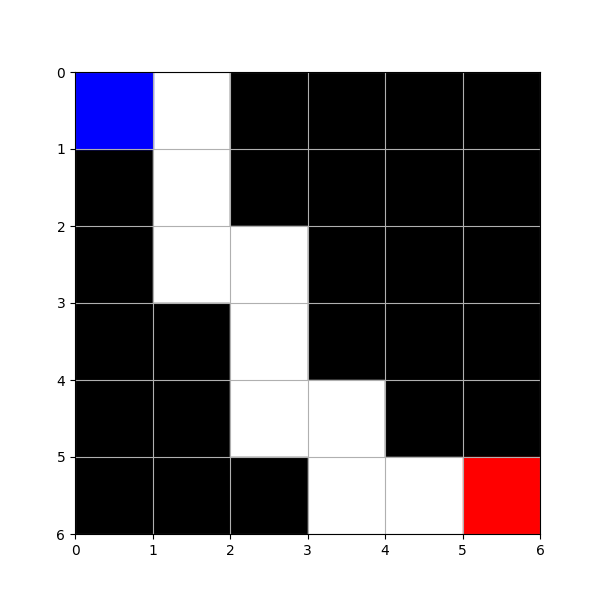

In [34]:
import imageio.v2 as imageio
gif_filename = 'output_newEnv.gif'
imageio.mimsave(gif_filename, frames, fps=2)

from IPython.display import Image, display
display(Image(filename=gif_filename))

#  **Homework**

1
---

In [35]:
# Train a Q-Learning agent on this custom environment.

env = FrozenLakeCustomEnv(max_steps=10)

num_runs = 3
num_episodes = 2000

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.5

regret_per_run = []
total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = QLearning(env, learning_rate, discount, epsilon_decay)
  regret, total_reward, frames = agent.train(num_episodes)

  regret_per_run.append(regret)
  total_reward_per_run.append(total_reward)

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [36]:
# Use grid search from scikit-learn to find the best parameters for discount factor, learning rate, and epsilon decay.

from sklearn.model_selection import ParameterGrid

parameter_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'discount': [0.9, 0.95, 0.99],
    'epsilon': [0.1, 0.3, 0.5, 1.0],
    'epsilon_decay': [0.9, 0.99, 0.995, 0.999],
}

grid = list(ParameterGrid(parameter_grid))

env = FrozenLakeCustomEnv(max_steps=10)

num_runs = 3
num_episodes = 2000

results = []

for params in tqdm(grid, desc="Grid Search"):
    regrets = []
    total_rewards = []

    for _ in tqdm(range(num_runs), desc = 'Runing'):
        env.reset()
        agent = QLearning(env, learning_rate, discount, epsilon_decay)
        regret, total_reward, frames = agent.train(num_episodes)

        regrets.append(regret)
        total_rewards.append(total_reward)

    avg_regret = np.mean(regrets)
    avg_reward = np.mean(total_rewards)

    results.append({'params': params, 'avg_reward': avg_reward, 'avg_regret': avg_regret})

best_result = max(results, key=lambda x: x['avg_reward'])
best_params = best_result['params']

Grid Search:   0%|          | 0/144 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

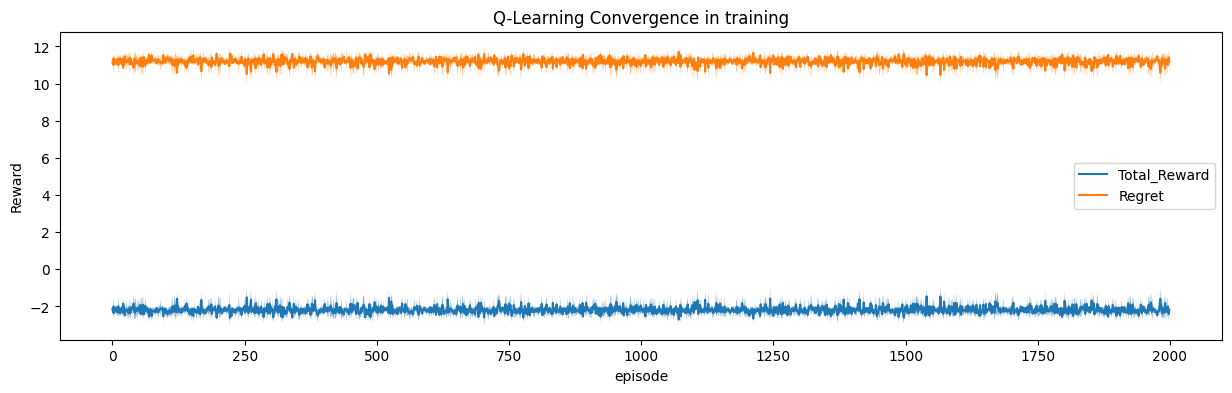

In [43]:
# Plot the reward and regret over 5 runs.

env = FrozenLakeCustomEnv(max_steps=10)

num_runs = 5
num_episodes = 2000

learning_rate = best_result['params']['learning_rate']
discount = best_result['params']['discount']
epsilon = best_result['params']['epsilon']
epsilon_decay = best_result['params']['epsilon_decay']

regret_per_run = []
total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = QLearning(env, learning_rate, discount, epsilon_decay)
  regret, total_reward, frames = agent.train(num_episodes)

  regret_per_run.append(regret)
  total_reward_per_run.append(total_reward)

plot_result(total_reward_per_run, regret_per_run, num_episodes , num_runs,
              figsize = (15,4), title = 'Q-Learning Convergence in training')

2
---

In [23]:
# Train a Monte Carlo agent on this custom environment.

env = FrozenLakeCustomEnv(max_steps=10)

num_runs = 3
num_episodes = 2000

discount = 0.998
epsilon = 1
epsilon_decay = 0.995

regret_per_run = []
total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = MonteCarlo(env, discount, epsilon, epsilon_decay)
  regret, total_reward = agent.train(num_episodes)

  regret_per_run.append(regret)
  total_reward_per_run.append(total_reward)

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# Use grid search from scikit-learn to find the best parameters for discount factor, epsilon and epsilon decay.

from sklearn.model_selection import ParameterGrid

parameter_grid = {
    'discount': [0.9, 0.95, 0.99],
    'epsilon': [0.1, 0.3, 0.5, 1.0],
    'epsilon_decay': [0.9, 0.99, 0.995, 0.999],
}

grid = list(ParameterGrid(parameter_grid))

env = FrozenLakeCustomEnv(max_steps=10)

num_runs = 3
num_episodes = 2000

results = []

for params in tqdm(grid, desc="Grid Search"):
    regrets = []
    total_rewards = []

    for _ in tqdm(range(num_runs), desc = 'Runing'):
        env.reset()
        agent = MonteCarlo(env, discount, epsilon, epsilon_decay)
        regret, total_reward = agent.train(num_episodes)

        regrets.append(regret)
        total_rewards.append(total_reward)

    avg_regret = np.mean(regrets)
    avg_reward = np.mean(total_rewards)

    results.append({'params': params, 'avg_reward': avg_reward, 'avg_regret': avg_regret})

best_result = max(results, key=lambda x: x['avg_reward'])
best_params = best_result['params']

Grid Search:   0%|          | 0/48 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Runing:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

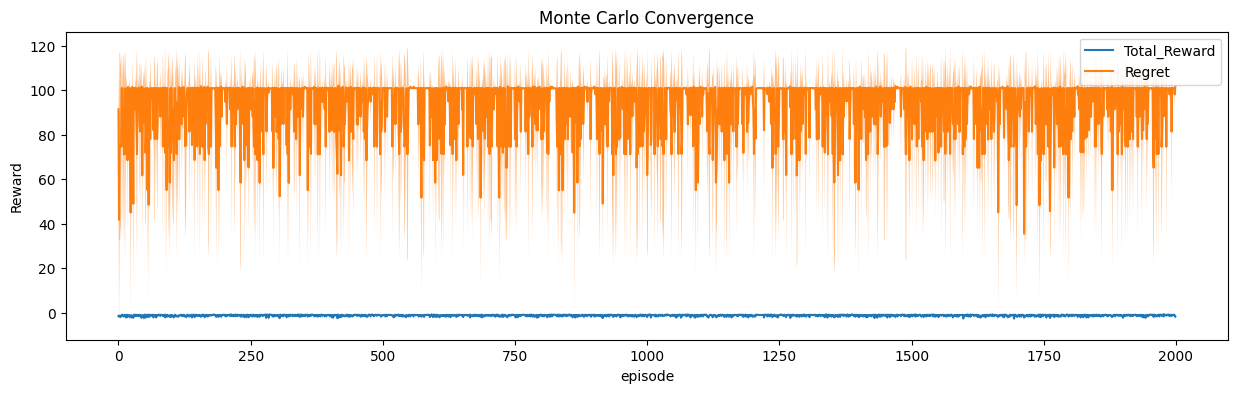

In [42]:
# Plot the reward and regret over 5 runs.

env = FrozenLakeCustomEnv(max_steps=10)

num_runs = 3
num_episodes = 2000

discount = best_result['params']['discount']
epsilon = best_result['params']['epsilon']
epsilon_decay = best_result['params']['epsilon_decay']

regret_per_run = []
total_reward_per_run =[]

for _ in tqdm(range(num_runs), desc = 'Runing'):
  env.reset()
  agent = MonteCarlo(env, discount, epsilon, epsilon_decay)
  regret, total_reward = agent.train(num_episodes)

  regret_per_run.append(regret)
  total_reward_per_run.append(total_reward)

plot_result(total_reward_per_run, regret_per_run, num_episodes , num_runs,
              figsize = (15,4), title = 'Monte Carlo Convergence')